<a href="https://colab.research.google.com/github/jefmabo/image-segmentation-activity/blob/main/PGC302B_Atividade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Atividade**

## Aluno: Jeferson Martins Borges
## Matr√≠cula: 12412CCP015

**Especifica√ß√£o do Problema:**

O objetivo deste trabalho √© analisar os m√©todos empregados em etapas de processamento da m√≠dia imagem. Vamos analisar as estrat√©gias empregadas na etapa de segmenta√ß√£o e extra√ß√£o de caracter√≠sticas das imagens. Ser√° investigado o m√©todo mais robusto para a etapa de segmenta√ß√£o baseado em segmenta√ß√£o por similaridade. Em seguida, explorado um algoritmo de extra√ß√£o de caracter√≠sticas baseado em propriedades de textura. As implementa√ß√µes devem ocorrer em ambiente Google CoLab com a linguagem de programa√ß√£o Python.

$\space$
$\space$


**Dataset**

O dataset que iremos empregar neste estudo foi proposto por Ghaderzadeh, M, Aria, M, Hosseini, A, Asadi, F, Bashash, D, Abolghasemi, H. A fast and efficient CNN model for B-ALL diagnosis and its subtypes classification using peripheral blood smear images. Int J Intell Syst. 2022; 37: 5113- 5133. doi:10.1002/int.22753.

As imagens desse conjunto de dados foram preparadas no laborat√≥rio de medula √≥ssea do Hospital Taleqani (Teer√£). Esse conjunto de dados consiste em 3.256 imagens de manchas de sangue perif√©rico (PBS) de 89 pacientes com suspeita de leucemia linfobl√°stica aguda (LLA), cujas amostras de sangue foram preparadas e coradas por uma equipe de laborat√≥rio. Esse conjunto de dados foi dividido em duas classes: benigna e maligna. A primeira compreende hematog√¥nias que se assemelham muito aos casos de LLA, entretanto, essa c√©lula precursora hematopoi√©tica √© benigna, n√£o requer quimioterapia. O grupo de LLA com tr√™s subtipos de linfoblastos malignos: LLA pr√©-B inicial, pr√©-B e pr√≥-B. Todas as imagens foram obtidas com uma c√¢mera Zeiss em um microsc√≥pio com amplia√ß√£o de 100 vezes e salvas como arquivos JPG. Um especialista que utilizou a ferramenta de citometria de fluxo fez a marca√ß√£o do padr√£o ouro dos tipos e subtipos dessas c√©lulas.

O dataset esta dispon√≠vel no link: https://www.kaggle.com/datasets/mehradaria/leukemia/data.

$\space$
$\space$

In [11]:
pip install -r .\requirements.txt


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


**Segmenta√ß√£o**

Em nossa disciplina, apresentamos t√©cnicas de segmenta√ß√£o baseadas em similiaridade (thresholding - limiariza√ß√£o) para processos sobre a m√≠dia imagem.

1) Implemente um programa para segmenta√ß√£o de imagens baseado em limiariza√ß√£o adaptativa local para separa√ß√£o dos objetos em rela√ß√£o a regi√£o de fundo. Procure explorar os modelos de cores (RGB, HSV, etc) para investigar o desempenho sobre os diferentes modelos. O c√≥digo desse algoritmo deve ser implementado sem usar fun√ß√µes dispon√≠veis em bibliotecas da linguagem.


In [12]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from tabulate import tabulate
from scipy import stats
from scipy.stats import pearsonr
from sklearn.metrics import jaccard_score
from skimage.feature import graycomatrix, graycoprops

ORIGINAL_BENIGN_PATH = "./dataset/Original/Benign"
ORIGINAL_EARLY_PATH = "./dataset/Original/Early"
ORIGINAL_PRE_PATH = "./dataset/Original/Pre"
ORIGINAL_PRO_PATH = "./dataset/Original/Pro"

SEGMENTED_BENIGN_PATH = "./dataset/Segmented/Benign"
SEGMENTED_EARLY_PATH = "./dataset/Segmented/Early"
SEGMENTED_PRE_PATH = "./dataset/Segmented/Pre"
SEGMENTED_PRO_PATH = "./dataset/Segmented/Pro"

images_to_process = []
segmented_images = []

In [13]:
def get_all_images_in_folder(path):
    images_path = []

    for path, _, files in os.walk(ORIGINAL_BENIGN_PATH):
        for file in files:
            images_path.append(f"{path}/{file}")
            print()

    return images_path

In [14]:

# Fun√ß√£o para converter a imagem RGB para escala de cinza
def rgb_to_grayscale(image):
    grayscale_image = []
    for row in image:
        grayscale_row = []
        for pixel in row:
            # Aplicando a f√≥rmula: 0.299*R + 0.587*G + 0.114*B
            gray_value = int(0.299 * pixel[0] + 0.587 * pixel[1] + 0.114 * pixel[2])
            grayscale_row.append(gray_value)
        grayscale_image.append(grayscale_row)
    return grayscale_image


In [15]:
def rgb_to_hsv(image):
    # Obter largura e altura da imagem
    width = len(image)
    height = len(image[0])

    hsv_image = []
    for y in range(height):
        hsv_row = []
        for x in range(width):
            pixel = []
            r, g, b = image[x][y]

            # # Normalizar os valores RGB para o intervalo [0, 1]
            r, g, b = r / 255.0, g / 255.0, b / 255.0
            
            # Encontrar o m√°ximo e m√≠nimo dos valores normalizados
            c_max = max(r, g, b)
            c_min = min(r, g, b)
            delta = c_max - c_min

            # Calcular H (Hue)
            if delta == 0:
                h = 0
            elif c_max == r:
                h = 60 * (((g - b) / delta) % 6)
            elif c_max == g:
                h = 60 * (((b - r) / delta) + 2)
            elif c_max == b:
                h = 60 * (((r - g) / delta) + 4)
            
            # Calcular S (Saturation)
            s = 0 if c_max == 0 else delta / c_max
            
            # Calcular V (Value)
            v = c_max
            
            pixel.append(h)
            pixel.append(s)
            pixel.append(v)

            hsv_row.append(pixel)
        
        hsv_image.append(hsv_row)

    return hsv_image

In [16]:
def grayscale_histogram(image):

    grayscale_image = rgb_to_grayscale(image)

    histogram = [0] * 256

    width = len(grayscale_image)
    height = len(grayscale_image[0])

    for y in range(height):
        for x in range(width):
            pixel = grayscale_image[x][y]
            histogram[pixel] += 1

    return histogram

In [17]:
# Fun√ß√£o para aplicar limiariza√ß√£o adaptativa local
def adaptive_thresholding(image, window_size, c):
    height = len(image)
    width = len(image[0])
    binary_image = [[0 for _ in range(width)] for _ in range(height)]
    grayscale_image = rgb_to_grayscale(image)

    for i in range(height):
        for j in range(width):
            # Determina a janela ao redor do pixel atual
            half_window = window_size // 2
            min_i = max(i - half_window, 0)
            max_i = min(i + half_window, height - 1)
            min_j = max(j - half_window, 0)
            max_j = min(j + half_window, width - 1)

            # Calcula a m√©dia dos pixels dentro da janela
            local_sum = 0
            count = 0
            for x in range(min_i, max_i + 1):
                for y in range(min_j, max_j + 1):
                    local_sum += grayscale_image[x][y]
                    count += 1
            local_mean = local_sum // count

            # Aplica o limiar adaptativo
            if grayscale_image[i][j] > local_mean - c:
                binary_image[i][j] = 255  # Objetos
            else:
                binary_image[i][j] = 0  # Fundo

    return binary_image

In [18]:
images_to_process =  get_all_images_in_folder(ORIGINAL_BENIGN_PATH)
# images_to_process =  get_all_images_in_folder(ORIGINAL_EARLY_PATH)
# images_to_process =  get_all_images_in_folder(ORIGINAL_PRE_PATH)
# images_to_process =  get_all_images_in_folder(ORIGINAL_PRO_PATH)

segmented_images =  get_all_images_in_folder(SEGMENTED_BENIGN_PATH)
# segmented_images =  get_all_images_in_folder(SEGMENTED_EARLY_PATH)
# segmented_images =  get_all_images_in_folder(SEGMENTED_PRE_PATH)
# segmented_images =  get_all_images_in_folder(SEGMENTED_PRO_PATH)

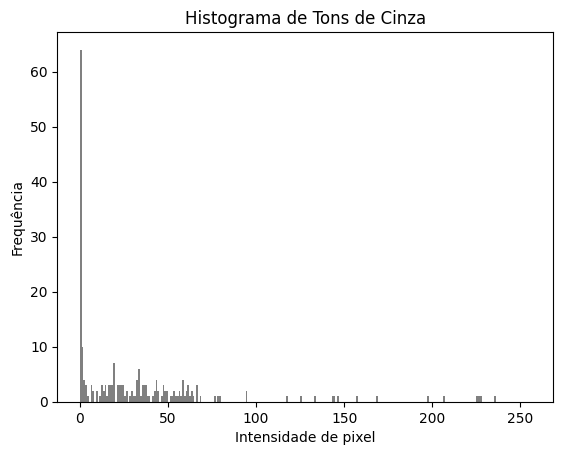

In [19]:
image = cv2.imread(images_to_process[0])
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

histogram = grayscale_histogram(image_rgb)

plt.hist(histogram, bins=256, range=(0, 256), color='gray')
plt.title('Histograma de Tons de Cinza')
plt.xlabel('Intensidade de pixel')
plt.ylabel('Frequ√™ncia')
plt.show()

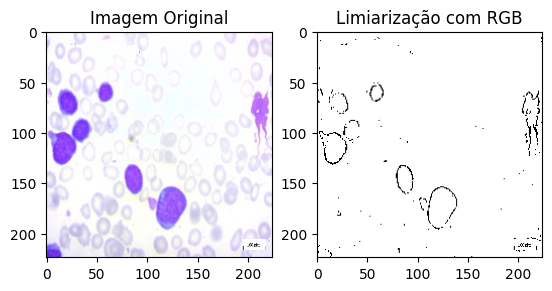

In [20]:
rgb_thresholding = adaptive_thresholding(image_rgb, window_size=3, c=10)

plt.subplot(1, 2, 1)
plt.imshow(image_rgb, cmap='gray')
plt.title('Imagem Original')

plt.subplot(1, 2, 2)
plt.imshow(rgb_thresholding, cmap='gray')
plt.title('Limiariza√ß√£o com RGB')

plt.show()

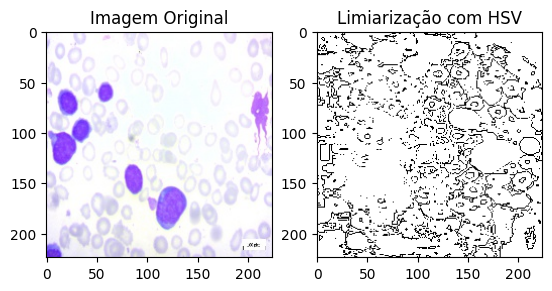

In [21]:
image_hsv = rgb_to_hsv(image_rgb)
hsv_thresholding = adaptive_thresholding(image_hsv, window_size=3, c=10)

plt.subplot(1, 2, 1)
plt.imshow(image_rgb, cmap='gray')
plt.title('Imagem Original')

plt.subplot(1, 2, 2)
plt.imshow(hsv_thresholding, cmap='gray')
plt.title('Limiariza√ß√£o com HSV')

plt.show()


2) Em seguida, usando a biblioteca OpenCV, fa√ßa a implementa√ß√£o da limiariza√ß√£o de Otsu. Fa√ßa uma investiga√ß√£o sobre diferentes bibliotecas Python para processamento de imagem e escolha duas outras t√©cnicas de limiariza√ß√£o dispon√≠veis para uma compara√ß√£o entre os m√©todos.

In [22]:
image = cv2.imread(images_to_process[0], cv2.IMREAD_GRAYSCALE)
segmented_image = cv2.imread(segmented_images[0], cv2.IMREAD_GRAYSCALE)

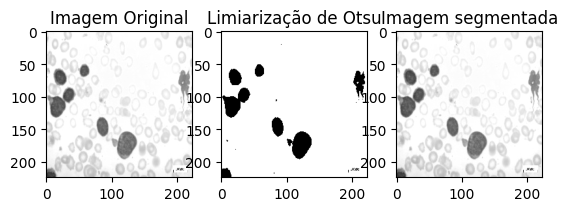

In [23]:
_, otsu_threshold = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Imagem Original')

plt.subplot(1, 3, 2)
plt.imshow(otsu_threshold, cmap='gray')
plt.title('Limiariza√ß√£o de Otsu')

plt.subplot(1, 3, 3)
plt.imshow(segmented_image, cmap='gray')
plt.title('Imagem segmentada')

plt.show()

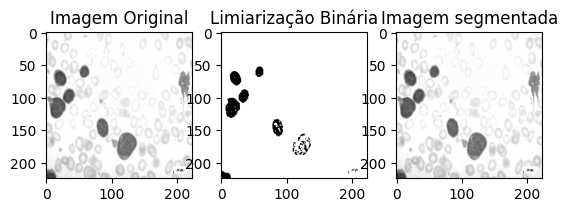

In [24]:
_, binary_threshold = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Imagem Original')

plt.subplot(1, 3, 2)
plt.imshow(binary_threshold, cmap='gray')
plt.title('Limiariza√ß√£o Bin√°ria')

plt.subplot(1, 3, 3)
plt.imshow(segmented_image, cmap='gray')
plt.title('Imagem segmentada')

plt.show()

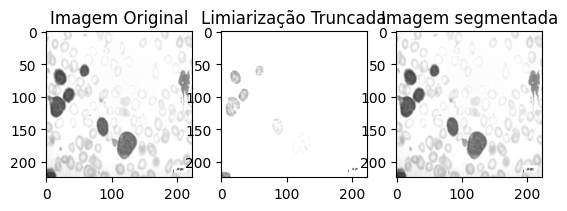

In [25]:
_, trunc_threshold = cv2.threshold(image, 127, 255, cv2.THRESH_TRUNC)

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Imagem Original')

plt.subplot(1, 3, 2)
plt.imshow(trunc_threshold, cmap='gray')
plt.title('Limiariza√ß√£o Truncada')

plt.subplot(1, 3, 3)
plt.imshow(segmented_image, cmap='gray')
plt.title('Imagem segmentada')

plt.show()

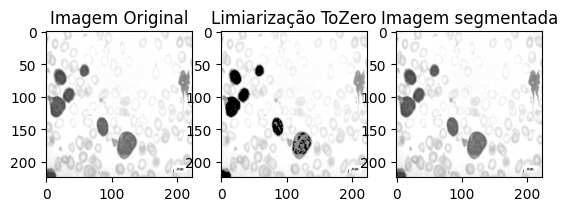

In [26]:
_, tozero_threshold = cv2.threshold(image, 127, 255, cv2.THRESH_TOZERO)

plt.subplot(1, 3, 1)
plt.imshow(image, cmap='gray')
plt.title('Imagem Original')

plt.subplot(1, 3, 2)
plt.imshow(tozero_threshold, cmap='gray')
plt.title('Limiariza√ß√£o ToZero')

plt.subplot(1, 3, 3)
plt.imshow(segmented_image, cmap='gray')
plt.title('Imagem segmentada')

plt.show()

3) Fa√ßa a aplica√ß√£o das diversas t√©cnicas sobre o conjunto de imagens proposto para o estudo.

4) Avalie os resultados em rela√ß√£o as m√°scaras dispon√≠veis na pasta "Segmented". Obtenha os valores das m√©tricas IoU (Intersection over Union) e coeficiente Dice usadas em segmenta√ß√£o.

A m√©trica IoU mede a sobreposi√ß√£o entre a √°rea prevista e a √°rea real:

$\text{IoU} = \frac{|A \cap B|}{|A \cup B|}$

Onde:
ùê¥ - √© o conjunto de pixels da segmenta√ß√£o prevista, ùêµ - √© o conjunto de pixels da segmenta√ß√£o verdadeira, ‚à© - representa a interse√ß√£o dos conjuntos e ‚à™ - representa a uni√£o dos conjuntos.

In [27]:
def iou(processed_image, ground_truth):
    # Converter para booleanos (0 e 1)
    processed_image = np.asarray(processed_image, dtype=np.bool_)
    ground_truth = np.asarray(ground_truth, dtype=np.bool_)

    # Calcular a interse√ß√£o
    intersection = np.logical_and(processed_image, ground_truth)
    # Calcular a uni√£o
    union = np.logical_or(processed_image, ground_truth)
    
    # IoU = Interse√ß√£o / Uni√£o
    iou = np.sum(intersection) / np.sum(union)
    return iou

O coeficiente de Dice mede a similaridade entre dois conjuntos, o qual √© dado por:

$\text{Dice} = \frac{2 |A \cap B|}{|A| + |B|}$

Onde: ùê¥ - √© o conjunto de pixels da segmenta√ß√£o prevista, ùêµ - √© o conjunto de pixels da segmenta√ß√£o verdadeira e ‚à© representa a interse√ß√£o dos conjuntos.

In [28]:
def dice(processed_image, ground_truth):
    # Converter para booleanos (0 e 1)
    processed_image = np.asarray(processed_image, dtype=np.bool_)
    ground_truth = np.asarray(ground_truth, dtype=np.bool_)

    # Calcular a interse√ß√£o
    intersection = np.logical_and(processed_image, ground_truth)
    
    # Dice = 2 * Interse√ß√£o / (Predi√ß√£o + Ground Truth)
    dice = 2 * np.sum(intersection) / (np.sum(processed_image) + np.sum(ground_truth))
    return dice

In [29]:
ostu_iou_result = iou(otsu_threshold, segmented_image)
ostu_dice_result = dice(otsu_threshold, segmented_image)

binary_iou_result = iou(binary_threshold, segmented_image)
binary_dice_result = dice(binary_threshold, segmented_image)

trunc_iou_result = iou(trunc_threshold, segmented_image)
trunc_dice_result = dice(trunc_threshold, segmented_image)

tozero_iou_result = iou(tozero_threshold, segmented_image)
tozero_dice_result = dice(tozero_threshold, segmented_image)

In [30]:
data = [
    ["Otsu", ostu_iou_result, ostu_dice_result],
    ["Binary", binary_iou_result, binary_dice_result],
    ["Trunc", trunc_iou_result, trunc_dice_result],
    ["Tozero", tozero_iou_result, tozero_dice_result]
]

# Cabe√ßalhos da tabela
headers = ["M√©todo", "IoU", "Coeficiente de Dice"]

# Gerar a tabela
print(tabulate(data, headers=headers, tablefmt="grid"))

+----------+----------+-----------------------+
| M√©todo   |      IoU |   Coeficiente de Dice |
+==========+==========+=======================+
| Otsu     | 0.926778 |              0.961998 |
+----------+----------+-----------------------+
| Binary   | 0.963309 |              0.981312 |
+----------+----------+-----------------------+
| Trunc    | 1        |              1        |
+----------+----------+-----------------------+
| Tozero   | 0.963309 |              0.981312 |
+----------+----------+-----------------------+


5) Use t√©cnicas estat√≠sticas que quantificam o desempenho dos modelos de segmenta√ß√£o para uma compara√ß√£o dos resultados. Para as compara√ß√µes entre modelos, voc√™ pode usar os intervalos de confian√ßa ou ANOVA. Tamb√©m pode ser considerado os testes n√£o param√©tricos (Wilcoxon, Mann-Whitney).

$IC = \bar{x} \pm Z \times \frac{s}{\sqrt{n}}$


$\space$
$\space$

In [31]:
def trust_index(data, confidence=0.95):
    x = np.mean(data)
    n = len(data)
    s = np.std(data, ddof=1)
    z = stats.norm.ppf(1 - (1 - confidence) / 2)
    standart_error = s / np.sqrt(n)
    ic = z * standart_error
    return x, x - ic, x + ic


**Extra√ß√£o de Caracter√≠sticas**

6) Crie um programa que leia as imagens do dataset sem segmenta√ß√£o e calcule a matriz de coocorr√™ncia numa representa√ß√£o de 256 n√≠veis de intensidades. Como as imagens est√£o em RGB fa√ßa a convers√£o para n√≠veis de cinza. Use as orienta√ß√µes de 0, 45, 90 e 135 graus com d = 1, d = 2, d = 3 e d = 4. Calcule a m√©dia e o desvio padr√£o das matrizes.

In [32]:
distancies = [1, 2, 3, 4]
angles = [0, np.pi/4, np.pi/2, 3*np.pi/4]
glcm_images = []
glcm_ground_thruths = []

for i in range(len(images_to_process)):
    image = cv2.imread(images_to_process[i], cv2.IMREAD_GRAYSCALE)
    ground_thruth = cv2.imread(segmented_images[i], cv2.IMREAD_GRAYSCALE)

    glcm_image = graycomatrix(image, distances=distancies, angles=angles, levels=256, symmetric=True, normed=True)
    glcm_ground_thruth = graycomatrix(ground_thruth, distances=distancies, angles=angles, levels=256, symmetric=True, normed=True)

    glcm_images.append(glcm_image)
    glcm_ground_thruths.append(glcm_ground_thruth)

7) Utilize as matrizes de coocorr√™ncia e calcule 5 principais descritores propostos por Haralick.

In [33]:
def haralick_descriptors(glcm):
    contrast = graycoprops(glcm, prop='contrast')[0, 0]
    energy = graycoprops(glcm, prop='energy')[0, 0]
    correlation = graycoprops(glcm, prop='correlation')[0, 0]
    homogeneity = graycoprops(glcm, prop='homogeneity')[0, 0]
    glcm_norm = glcm / np.sum(glcm)
    entropy = -np.sum(glcm_norm * np.log2(glcm_norm + np.finfo(float).eps))

    return [contrast, energy, correlation, homogeneity, entropy]    

8) Fa√ßa uma an√°lise de similaridade entre as classes investigadas por meio de caracter√≠sticas extra√≠das com os descritores e a varia√ß√£o de parametriza√ß√£o. Para essa an√°lise, use a similaridade de Jaccard e o coeficiente de correla√ß√£o de Pearson.

A similaridade de Jaccard pode ser aplicada diretamente se voc√™ tratar os descritores de Haralick como conjuntos de valores binarizados ou discreto:

$J(A, B) = \frac{|A \cap B|}{|A \cup B|}$

onde: ‚à£A‚à©B‚à£‚à£A‚à©B‚à£ √© o tamanho da interse√ß√£o entre AA e BB, e ‚à£A‚à™B‚à£‚à£A‚à™B‚à£ √© o tamanho da uni√£o dos conjuntos AA e BB.

In [34]:
def jaccard_similarity(vector1, vector2):
    intersection = np.sum(np.minimum(vector1, vector2))
    union = np.sum(np.maximum(vector1, vector2))
    result = intersection / union if union != 0 else 0
    print(result)
    return result

coeficiente de correla√ß√£o de Pearson:

$ r = \frac{\sum_{i=1}^{n}(x_i - \bar{x})(y_i - \bar{y})}{\sqrt{\sum_{i=1}^{n}(x_i - \bar{x})^2}\sqrt{\sum_{i=1}^{n}(y_i - \bar{y})^2}}$

onde, x e y s√£o as duas vari√°veis, n √© o n√∫mero de observa√ß√µes, xÃÑ e »≥ s√£o as m√©dias de x e y, respectivamente.

In [35]:
def pearson_correlation(vetor1, vetor2):
    coefficients = []
    p_values = []
    for i in range(len(vetor1)):
        coef, p_valor = pearsonr([vetor1[i]], [vetor2[i]])
        coefficients.append(coef)
        p_values.append(p_valor)
    return coefficients, p_values

In [37]:
image_contrast = []
image_energy = []
image_correlation = []
image_homogeneity = []
image_entropy = []

ground_thruth_contrast = []
ground_thruth_energy = []
ground_thruth_correlation = []
ground_thruth_homogeneity = []
ground_thruth_entropy = []

jaccard_similarities = []
jaccard_scores = []

pearson_coefficients = []
pearson_values = []

for i in range(len(glcm_images)):
    glcm_image = glcm_images[i]
    glcm_ground_thruth = glcm_ground_thruths[i]

    haralick_image = haralick_descriptors(glcm_image)
    haralick_ground_thruth = haralick_descriptors(glcm_ground_thruth)

    haralick_image_bin = np.array([1 if valor > 0.5 else 0 for valor in haralick_image])
    haralick_ground_thruth_bin = np.array([1 if valor > 0.5 else 0 for valor in haralick_ground_thruth])

    jaccard = jaccard_similarity(haralick_image_bin, haralick_ground_thruth_bin)

    # jaccard_s = jaccard_score(haralick_image_bin, haralick_ground_thruth_bin)

    # print(jaccard)
    # print(jaccard_s)

    print(len(haralick_image))
    print(len(haralick_ground_thruth))

    pearson_coefficient, pearson_value = pearson_correlation(haralick_image, haralick_ground_thruth)

    image_contrast.append(haralick_image[0])
    image_energy.append(haralick_image[1])
    image_correlation.append(haralick_image[2])
    image_homogeneity.append(haralick_image[3])
    image_entropy.append(haralick_image[4])

    ground_thruth_contrast.append(haralick_ground_thruth[0])
    ground_thruth_energy.append(haralick_ground_thruth[1])
    ground_thruth_correlation.append(haralick_ground_thruth[2])
    ground_thruth_homogeneity.append(haralick_ground_thruth[3])
    ground_thruth_entropy.append(haralick_ground_thruth[4])

    jaccard_similarities.append(jaccard)
    # jaccard_scores.append(jaccard_s)

    pearson_coefficients.append(pearson_coefficient)
    pearson_values.append(pearson_value)
    

1.0
[1 0 1 0 1]
[1 0 1 0 1]
5
5


ValueError: x and y must have length at least 2.

9) Discuta os resultados e as observa√ß√µes em rela√ß√£o as varia√ß√µes de par√¢metros e a representa√ß√£o pela t√©cnica para as classes investigadas.

10) Repita esses experimentos sobre as imagens segmentadas com a melhor resultado da t√©cnica de segmenta√ß√£o obtida na etapa 5). Avalie o comportamento dos descritores com informa√ß√µes segmentadas. Fa√ßa discuss√µes semelhantes as observa√ß√µes obtidas na quest√£o 9) com as imagens segmentadas.


$\space$
$\space$

**Entrega**


O trabalho deve ser submetido por meio da plataforma Microsoft Teams.

Data de entrega: **23/10/2024**

Essa atividade pode ser realizada em grupos de dois estudantes, os quais dever√£o submeter o relat√≥rio pela plataforma Teams.

A entrega do trabalho deve conter os seguintes itens:
* codigo-fonte: o arquivo final deve estar no formato .zip ou no formato tgz, contendo todos os programas ou dados necessarios para sua execu√ß√£o. Tamb√©m deve ter um cabe√ßalho com os dados dos estudantes (Nome e Matr√≠cula).
* relatorio: deve conter uma descri√ß√£o dos algoritmos e das estruturas de dados, considera√ß√µes adotadas na solu√ß√£o do problema, testes executados, eventuais limita√ß√µes ou situa√ß√µes especiais n√£o explorada pelo programa.